# Designing Nonlinear Fluid Networks to Support Many Equilibria
#### *Nathaniel Karst (Babson College) and John Geddes (University of Strathcylde)*

We present a design framework for nonlinear fluid networks that enables the systematic construction of architectures supporting extremely large numbers of steady states under fixed boundary conditions. By expressing network flows in the low dimensional cycle space, zero-flow conditions define an affine hyperplane arrangement whose bounded complex corresponds exactly to acyclic flow configurations of the network. Coupling this geometric representation to a nonlinear flow–resistance model for two-phase fluids, we show that equilibria satisfy a reduced set of nonlinear Kirchhoff loop equations and that equilibria with bounded, positive resistances exist if and only if the corresponding cycle-space point lies in the interior of the bounded complex. Exploiting this structure, we introduce (non)linear programming and heuristic design methods that tune network geometry to place equilibria at interior intersections where multiple vessels carry zero flow, and then strengthen nonlinearity to induce the formation of multiple equilibria. Applied to several microvascular-inspired networks, this approach yields designs supporting tens of thousands of distinct equilibria -- far exceeding prior reports -- and scales well to much larger networks, suggesting that extreme multistability is a generic and engineerable feature of nonlinear flow networks.

## Helper Functions

In [1]:
import random
import numpy as np
import scipy as sp
from scipy.spatial import HalfspaceIntersection, ConvexHull

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import IntProgress
from IPython.display import display

import os
import pickle
import time

import skeleton
import skimming
from network import Network

import networkx as nx
import pandas as pd

from collections import defaultdict
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def network_info():
    eig = np.linalg.eig(N.inc@N.inc.T)[0]
    eig_nonzero = eig[np.where(np.abs(eig)>1e-6)[0]]
    num_vertices = np.prod(eig_nonzero)/N.nNodes
    print(f'|V_G|: {N.nNodes}')
    print(f'|E_G|: {N.nVessels}')
    print(f'k: {N.k}')
    print(f'z: {np.sum(N.z)}')
    print(f'|V_A|: {num_vertices}')
    print(f'log(|V_A|): {np.log(num_vertices)}')    

def get_h(q):
    rhs = np.zeros(N.nVessels)

    # sign-adjusted incidence matrix
    X = N.inc@np.diag(np.sign(q))
    exterior = np.array((np.abs(N.inc).sum(axis=1) == 1)).flatten()    
    interior = np.array((np.abs(N.inc).sum(axis=1) == 3)).flatten()    
    net_in = np.array(X.sum(axis=1) == 1).flatten()
    net_out = np.array(X.sum(axis=1) == -1).flatten()

    # conservation of mass at all interior nodes
    CQ = N.inc[N.interiorNodes,:]@np.diag(q)

    # plasma skimming at all diverging nodes
    div = np.where(np.bitwise_and(interior,net_out))[0]
    for node in div:
        idx_in = np.where(X[node,:] > 0)[0][0]
        idx_out = np.min(np.where(X[node,:] < 0)[0])
        row = np.zeros(N.nVessels)
        row[idx_in] = -skimming.skimming_kj(np.abs(q[idx_out]/q[idx_in]),N.pPlasma)[0]
        row[idx_out] = 1
        CQ = np.concatenate((CQ,row.reshape(1,-1)))

    # boundary conditions at all inlets
    inlets =  np.where(np.bitwise_and(exterior,net_out))[0]
    for i,inlet in enumerate(inlets):
        row = np.zeros(N.nVessels)
        inlet_vessel = np.where(N.inc[inlet])[0][0]            
        
        row[inlet_vessel] = 1
        CQ = np.concatenate((CQ,row.reshape(1,-1)))              
        rhs[-(len(inlets)-i)] = N.h_bcs[inlet_vessel]
        
    return(np.linalg.inv(CQ)@rhs)

def equilibrium_relation(a):
    q = N.K@a + N.q0
    h = get_h(q)
    r = N.l/N.d**4*np.exp(h*N.delta)
    return (N.K).T@(q*r)

def tune_r0(z,all_plasma=True,rU = np.inf,pert=0):
    # pseudo-inverse here in case |z| < N.k
    # optional small perturbation, as things can go haywire if flows are actually zero;
    # note that since we're pertubring a rather than q, flow conservation will still hold
    a = -np.linalg.pinv(N.K[z,:])@N.q0[z] + pert*np.random.random(N.k)
    q = N.K@a + N.q0
    
    # minimize total nominal resistance 
    c = np.ones(len(N.e))

    # subject to the system being in equilibrium
    R = np.diag(np.exp((1-all_plasma)*get_h(q)*N.delta))
    A_eq = (N.K).T@R@np.diag(q)
    b_eq = np.zeros(N.k)
    result = sp.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(1,rU))

    # in edge cases, e.g., in the greedy z builder
    # |z| > k, and the pseudoinverse above won't notice that 
    # q[z] != 0; do one final check to make sure we're not 
    # totally off base
    if np.max(q[z]) > 1e-6:
        result.success = False
        result.x = None
    return result   

### Plotting Helpers

In [3]:
def plot_loop_equations(a_min=-2,a_max=2,n=100):
    A0,A1 = np.meshgrid(np.linspace(a_min,a_max,n),np.linspace(a_min,a_max,n))
    L0 = np.nan*np.ones(A0.shape)
    L1 = np.nan*np.ones(A0.shape)
    for i in range(A0.shape[0]):
        for j in range(A0.shape[1]):
                L = equilibrium_relation([A0[i,j],A1[i,j]])
                L0[i,j] = L[0]
                L1[i,j] = L[1]
            
    contour1 = plt.contour(A0,A1,L0,0,linestyles='-',colors='k')
    contour2 = plt.contour(A0,A1,L1,0,linestyles='-',colors='b')
    
    plt.xlim((a_max,a_max))
    plt.ylim((a_max,a_max))

def plot_convex_bounding_box():
    QL = np.concatenate((-N.K,-N.q0.reshape(-1,1)-1),axis=1)
    QU = np.concatenate((N.K,N.q0.reshape(-1,1)-1),axis=1)
    hs = HalfspaceIntersection(np.concatenate((QL,QU),axis=0), np.zeros(N.k))
    
    # Order vertices around the hull
    hull = ConvexHull(hs.intersections)
    verts_ordered = hs.intersections[hull.vertices]

    plt.plot(verts_ordered[:,0],verts_ordered[:,1],'k')
    plt.plot(verts_ordered[[-1,0],0],verts_ordered[[-1,0],1],'k')    

def alpha_space_pub(kirchoff=False,legend=False,loc='upper left',a_min=-2,a_max=2,n_loop_grid=100,corners=None,legend_ncol=1):
    N.plot_alpha_space()

    # adjust python indexing to math indexing
    if legend:
        plt.gca().legend(['$q_{'+str(i+1)+'} = 0$' for i in N.interiorFlows],loc=loc,ncol=legend_ncol)
    else:
        plt.gca().get_legend().remove()
        
    if kirchoff:
        plot_loop_equations(n=n_loop_grid)

    # highlight the finite regions of the polytope
    if corners:
        # convert line pairs to alpha pairs
        verts = []
        for vert in corners:
            a = -np.linalg.inv(N.K[vert,:])@N.q0[vert]
            verts.append(a)
        verts = np.array(verts)
        
        # first make the whole region semi-transparent black ...
        plt.gca().fill([a_min,a_max,a_max,a_min],[a_max,a_max,a_min,a_min],facecolor='black',alpha=0.25,zorder=-100)
        
        # ... and then overlaying with white
        plt.gca().fill(verts[:,0], verts[:,1],facecolor='white',zorder=-99) 

    plt.xlim((a_min,a_max))
    plt.ylim((a_min,a_max))        

### Building Reversible Flow Sets

In [4]:
# to install : conda install conda-forge::pyomo
from pyomo.environ import *

def build_z_exact(qL, qU, rL, rU, k_zeros, epsilon=1e-9):
    M = ConcreteModel()
    M.E = RangeSet(0,N.nVessels-1)
    M.V = RangeSet(0,N.nNodes-1)

    # parameters
    J = N.inc #Param(initialize=N.inc)
    q_net = N.pq_bcs #Param(initialize=N.pq_bcs)
    M.eps = Param(initialize=epsilon, mutable=True)
    
    # variables
    M.p = Var(M.V, domain=Reals) # pressures
    M.q = Var(M.E, bounds=lambda _,e: (qL, qU)) # flows
    M.r = Var(M.E, bounds=lambda _,e: (rL, rU)) # resistances
    M.z = Var(M.E, domain=Binary) # 1: zero flow; 0: non-zero flow

    # minimize total resistance
    M.obj = Objective(expr=sum(M.r[e] for e in M.E), sense=minimize)

    # subject to...
    # flow conservation
    M.flow_upper = Constraint(M.V, rule=lambda M,v: sum(J[v, e]*M.q[e] for e in M.E) - q_net[v] <= M.eps)
    M.flow_lower = Constraint(M.V, rule=lambda M,v: sum(J[v, e]*M.q[e] for e in M.E) - q_net[v] >= -M.eps)

    # exactly k_zeros zero flows
    M.zero_upper = Constraint(M.E, rule=lambda M,e:  M.q[e] <=  qU*(1 - M.z[e]) + M.eps)
    M.zero_lower = Constraint(M.E, rule=lambda M,e:  M.q[e] >=  qL*(1 - M.z[e]) - M.eps)
    M.exact_k_zeros = Constraint(expr=sum(M.z[e] for e in M.E) == k_zeros)

    # at most one zero flow incident to each node
    # (not strictly necessary, but speeds things up by reducing search space)
    M.at_most_one_z_per_node = Constraint(M.V, rule=lambda M,v: sum(np.abs(J[v,e])*M.z[e] for e in M.E) <= 1)
    
    # (bilinear) Poiseuille
    M.poiseuille = Constraint(M.E, rule=lambda M,e: -M.r[e]*M.q[e] == sum(J.T[e,v]*M.p[v] for v in M.V))

    solver = SolverFactory("scip")
    solved = solver.solve(M)
    
    return np.array([np.abs(M.z[e].value) > 0.99 for e in M.E])

#### Relaxed 

In [5]:
# conda install conda-forge::cvxpy
import cvxpy as cp

def build_z_relaxed(qL, qU, rL, rU, k_zeros, epsilon=1e-9, solver="CBC", verbose=False):
    # parameters
    J = np.asarray(N.inc, float)
    q_net = N.pq_bcs.reshape(-1)
    
    p = cp.Variable(N.nNodes) # pressures
    q = cp.Variable(N.nVessels) # flows
    r = cp.Variable(N.nVessels) # resistances
    z = cp.Variable(N.nVessels, boolean=True) # 1: zero flow; 0: non-zero flow

    # minimize total resistance
    objective = cp.Minimize(cp.sum(r))

    # subject to...
    constraints = []

    # flow conservation
    constraints += [J@q == q_net ]

    # flow bounds and zero flow in k_zeros vessels
    constraints += [q <= epsilon + cp.multiply(qU, 1 - z)]
    constraints += [q >= cp.multiply(qL, 1 - z) - epsilon]
    constraints += [cp.sum(z) == k_zeros]

    # each node adjacent to at most 1 zero flow vessel
    constraints += [np.abs(J)@z <= 1]
    
    # resistance bounds
    constraints += [r >= rL, r <= rU]

    # McCormick envelopes for bilinear product J^T p = -Rq, e.g.,
    # (q - qL)*(r-rL) = qr - q*rL - r*qL + qL*rL > 0
    # => -J^T@p = Rq >= q*rL + r*qL - qL*rL
    constraints += [-J.T@p >= cp.multiply(qL, r) + cp.multiply(rL, q) - (qL * rL)]
    constraints += [-J.T@p >= cp.multiply(qU, r) + cp.multiply(rU, q) - (qU * rU)]
    constraints += [-J.T@p <= cp.multiply(qU, r) + cp.multiply(rL, q) - (qU * rL)]
    constraints += [-J.T@p <= cp.multiply(qL, r) + cp.multiply(rU, q) - (qL * rU)]

    # get rid of the floating pressure in the differentials
    constraints += [p[0] == 0]
    
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=getattr(cp, cp.CBC), verbose=verbose)

    return None if z.value is None else np.rint(z.value).astype(bool)

#### Greedy

In [41]:
def find_reversible_edges(N,a,verbose=False):
    incidence_matrix = N.inc@np.diag(np.sign(N.K@a + N.q0))
    num_nodes, num_edges = incidence_matrix.shape

    edges = []
    for edge_idx in range(num_edges):
        source = np.where(incidence_matrix[:, edge_idx] == -1)[0][0]
        target = np.where(incidence_matrix[:, edge_idx] == 1)[0][0]
        edges.append((source, target))

    net_in = np.sum(incidence_matrix,axis=1)

    # note that these edges will not be the edges above, 
    # so we actually need this argument
    def dfs_from_edges(edges, start_node):
        adjacency_list = {i: [] for i in range(num_nodes)}
        for u, v in edges:
            adjacency_list[u].append(v)
    
        visited = set()
        result = []
    
        def dfs(node):
            if node in visited:
                return
            visited.add(node)
            result.append(node)
            for neighbor in adjacency_list[node]:
                dfs(neighbor)

        dfs(start_node)    
        return result

    reversible_edges = []
    for edge_idx, (u, v) in enumerate(edges):
        tmp = edges.copy()
        nodes = tmp.pop(edge_idx) # can't use the reversed edge anymore
        reachable = dfs_from_edges(tmp, u)
        if np.abs(net_in[u] + 2) > 1: # u is now either source or sink
            if verbose: print(f'Reversing {edge_idx} creates source or sink')
            continue
        elif np.abs(net_in[v] - 2) > 1: # v is now either source or sink
            if verbose: print(f'Reversing {edge_idx} creates source or sink')
            continue
        elif v in reachable:  # (v,u) creates a cycle
            if verbose: print(f'Reversing {edge_idx} creates cycle')
            continue
        else:
            reversible_edges.append(edge_idx)

    reversible_edges = list(set(reversible_edges) - set(N.exteriorFlows))
            
    return reversible_edges 
    

def paths_from_edges(edges):
    # Normalize edges to undirected set: (min, max)
    undirected = set()
    for u, v in edges:
        if u == v:
            # Ignore self-loops (violates "at most two edges" premise for a simple path)
            continue
        a, b = (u, v) if u < v else (v, u)
        undirected.add((a, b))
    
    # Build adjacency (undirected)
    adj = defaultdict(set)
    for a, b in undirected:
        adj[a].add(b)
        adj[b].add(a)
    
    # Degree check (optional safety)
    for node, nbrs in adj.items():
        if len(nbrs) > 2:
            raise ValueError(f"Branching detected at {node}: degree {len(nbrs)} > 2.")
    
    unused = set(undirected)
    paths = []
    
    def walk_path(start, next_node):
        """Walk a maximal path starting from (start -- next_node)."""
        path_edges = []
        prev, cur = start, next_node
        # Add the first edge
        e = (prev, cur) if prev < cur else (cur, prev)
        unused.discard(e)
        path_edges.append((prev, cur))  # oriented as we traverse
        # Continue walking while we can
        while True:
            # Candidates are neighbors of cur except the node we came from
            candidates = [w for w in adj[cur] if w != prev]
            # Filter out those whose undirected edge is already used
            candidates = [w for w in candidates if ((cur, w) if cur < w else (w, cur)) in unused]
            if not candidates:
                break
            # In a no-branching graph, there can be at most one such candidate
            nxt = candidates[0]
            e = (cur, nxt) if cur < nxt else (nxt, cur)
            unused.discard(e)
            path_edges.append((cur, nxt))  # oriented forward
            prev, cur = cur, nxt
        return path_edges
    
    # 1) Start with endpoints (degree 1) to extract open paths
    endpoints = [n for n, nbrs in adj.items() if len(nbrs) == 1]
    visited_endpoints = set()
    for s in endpoints:
        if s in visited_endpoints:
            continue
        visited_endpoints.add(s)
        # If this endpoint has an unused edge, walk it
        for nbr in adj[s]:
            e = (s, nbr) if s < nbr else (nbr, s)
            if e in unused:
                paths.append(walk_path(s, nbr))
    
    # 2) Any remaining unused edges must belong to cycles (all degree 2)
    while unused:
        a, b = next(iter(unused))  # pick an arbitrary unused edge (undirected a--b)
        # Walk both directions to close the cycle; pick orientation arbitrarily as (a -> b ...)
        cycle = walk_path(a, b)
        # If the walk didn't return to 'a', we still have one unused edge back to the start;
        # but with degree ≤2 everywhere, walk_path will consume the whole cycle.
        paths.append(cycle)
    
    return paths

def build_z_greedy(rmax=100,all_plasma=True,showProgress=True,pert=0):
    rev = find_reversible_edges(N,np.zeros(N.k))
    edges = [N.e[i] for i in rev]
    
    paths = paths_from_edges(edges)
    
    paths_idx = []
    for path in paths:
        path_idx = []
        for edge in path:
            edge = list(edge)
            if edge not in edges:
                edge = [edge[1],edge[0]]
            path_idx.append(N.e.index(edge))
        paths_idx.append(path_idx)

    from IPython.display import display
    progress = IntProgress(min=0, max=len(paths_idx));
    
    if showProgress: display(progress)
    
    starts = []
    for i in range(len(paths_idx)):
        progress.value += 1
        tmp = []
        for j in range(i):
            if starts[j] == None:
                continue
            tmp +=  paths_idx[j][starts[j]::2]

        if len(paths_idx[i]) == 1:
            tmp0 = tmp + paths_idx[i]
            result0 = tune_r0(tmp0,all_plasma,pert=pert)
            if result0.success:
                if max(result0.x) < rmax:
                    starts += [0]
                    continue
            starts += [None]
            continue
        
        tmp0 = tmp + paths_idx[i][::2]
        result0 = tune_r0(tmp0,all_plasma,pert=pert)
    
        tmp1 = tmp + paths_idx[i][1::2]
        result1 = tune_r0(tmp1,all_plasma,pert=pert)    
    
        if not result0.success and not result1.success:
            starts += [None]
            continue
        elif result0.success and not result1.success:
            if max(result0.x) > rmax:
                starts += [None]
                continue
            starts += [0]
        elif not result0.success and result1.success:
            if max(result1.x) > rmax:
                starts += [None]
                continue        
            starts += [1]
        elif max(result0.x) < max(result1.x):
            if max(result0.x) > rmax:
                starts += [None]
                continue            
            starts += [0]
        else:
            if max(result1.x) > rmax:
                starts += [None]
                continue        
            starts += [1]
            
    z = []
    for j in range(len(starts)):
        if starts[j] == None:
            continue
        z +=  paths_idx[j][starts[j]::2]

    result = tune_r0(z,all_plasma,pert=pert)
    
    a = -np.linalg.pinv(N.K[z,:])@N.q0[z] + 1e-6*np.random.random(N.k)
    q = N.K@a + N.q0
    r = result.x
    p = np.linalg.pinv(N.inc.T)@(-q*r)
    
    z = [True if i in z else False for i in range(N.nVessels)]

    return z

In [7]:
def verify_solution(p,q,r,z):
    print(f'\tr in [{np.round(np.min(r),3)},{np.round(np.max(r),3)}]')
    print(f'\t|Jq - q_net|_infty = {np.round(np.max(np.abs(N.inc@q - N.pq_bcs)),4)}')
    print(f'\t|J^Tp + Rq|_infty = {np.round(np.max(np.abs(N.inc.T@p + q*r)),4)}')
    print(f'\tConfirmed Kirchoff: {tune_r0(np.where(z)[0]).success}')

## Data Generation

In [8]:
def z_builder_comparison(size_z,rU=10,pert=1e-9):
    start_time = time.time()
    qL = -1.1
    qU = 1.1
    rL = 1

    print('Greedy')
    start_time = time.time()
    z_greedy = build_z_greedy(rmax=rU,showProgress=False,all_plasma=False,pert=1e-9)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'\t Elapsed time: {elapsed_time:.4f} seconds')
    print(f'\t |z| = {sum(z_greedy)}')
    print(f'\t Tune r0: {tune_r0(z_greedy,pert=pert).success}')

    print('Relaxed')    
    start_time = time.time()
    z_relaxed = build_z_relaxed(qL, qU, rL, rU, size_z)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'\t Elapsed time: {elapsed_time:.4f} seconds')
    print(f'\t |z| = {sum(z_relaxed)}')
    print(f'\t Tune r0: {tune_r0(z_relaxed,pert=pert).success}')
 
    print('Exact')
    start_time = time.time()
    z_exact = build_z_exact(qL, qU, rL, rU, size_z, epsilon=1e-9)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'\t Elapsed time: {elapsed_time:.4f} seconds')
    print(f'\t |z| = {sum(z_exact)}')
    print(f'\t Tune r0: {tune_r0(z_exact,pert=pert).success}')

    return {'z_greedy':z_greedy, 'z_relaxed':z_relaxed, 'z_exact':z_exact}

In [9]:
def generate_manuscript_data(N,file_name,solver_type='exact',k_zeros=None,num_eq=1,d_z=2,rmax=10):
    if not hasattr(N,'z'):
        start_time = time.time()
        qL = -1.1
        qU = 1.1
        rL = 1
        rU = rmax
        if solver_type == 'exact':
            z = build_z_exact(qL, qU, rL, rU, k_zeros, epsilon=1e-9)
        elif solver_type == 'relaxed':
            z = build_z_relaxed(qL, qU, rL, rU, k_zeros)                      
        elif solver_type == 'greedy':
            z = build_z_greedy(rmax=rmax)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Reversible flows found in {elapsed_time:.4f} seconds")    
        
        N.z = z
        
    N.set_hematocrit_boundary_conditions('equal',0.0)    
    r0 = tune_r0(N.z,all_plasma=False,pert=1e-6).x
    N.l = r0
    N.d[N.z] = d_z
    N.set_hematocrit_boundary_conditions('equal',0.45)
    
    start_time = time.time()
    np.random.seed(2025)
    N.find_equilibria(num_eq)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Equilibria found in found in {elapsed_time:.4f} seconds")
    
    f = open(f'data/{file_name}.p','wb')
    pickle.dump(N,f)
    f.close()

### CarrLecoin

In [12]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
N.e = [list(ee) for ee in N.e]
inlets = [8,9,10]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)

In [13]:
z_comparison_results = z_builder_comparison(2)

Greedy
	 Elapsed time: 0.0258 seconds
	 |z| = 2
	 Tune r0: True
Relaxed
	 Elapsed time: 0.0721 seconds
	 |z| = 2
	 Tune r0: True
Exact
	 Elapsed time: 0.8354 seconds
	 |z| = 2
	 Tune r0: True


### Forouzan

In [89]:
S = skeleton.Forouzan()
physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}
N = Network(params)

N.set_flow_boundary_conditions('equal',inlets=[0])

filename = 'forouzan'
if not os.path.isfile(f'data/{filename}.p'):
    generate_manuscript_data(N,filename,solver_type='exact',k_zeros=8,num_eq=100000)

In [19]:
z_comparison_results = z_builder_comparison(8)

Greedy
	 Elapsed time: 0.0322 seconds
	 |z| = 7
	 Tune r0: True
Relaxed
	 Elapsed time: 0.7034 seconds
	 |z| = 8
	 Tune r0: False
Exact
	 Elapsed time: 20.0354 seconds
	 |z| = 8
	 Tune r0: True


### Mesh

In [173]:
S = skeleton.PeriodicHoneycombSkeleton(4,4,0.3,seed=2025)
S.v[:,0] /= np.max(S.v[:,0])
S.v[:,1] /= np.max(S.v[:,1])

physParams = {'pPlasma':2, 'delta':np.log(100), 'h_bcs':np.zeros(len(S.e)), 'seed':2025, 'pq_bcs':np.zeros(S.v.shape[0]),'bc_type':'flow'}
params = {**S.get(), **physParams}  
N = Network(params)

N.d = np.ones(N.nVessels)
N.l = np.ones(N.nVessels)

N.set_flow_boundary_conditions('equal',inlets=[0,1,2,3])
N.set_hematocrit_boundary_conditions('equal',0.45)

filename = 'mesh'
if not os.path.isfile(f'data/{filename}.p'):
    generate_manuscript_data(N,filename,solver_type='exact',k_zeros=9,num_eq=100000)

In [174]:
z_comparison_results = z_builder_comparison(9)

Greedy
	 Elapsed time: 0.0400 seconds
	 |z| = 12
	 Tune r0: True
Relaxed
	 Elapsed time: 0.0558 seconds
	 |z| = 9
	 Tune r0: True
Exact
	 Elapsed time: 0.0564 seconds
	 |z| = 9
	 Tune r0: True


### Random

In [8]:
S = skeleton.PeriodicRandomSkeleton(25,seed=1234)
S.l = np.ones(S.l.shape)
S.d = np.ones(S.d.shape)
physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}
N = Network(params)

N.set_flow_boundary_conditions('equal',inlets=[0,1,2,3])
N.set_hematocrit_boundary_conditions('equal',0.45)

filename = 'random'
if not os.path.isfile(f'data/{filename}.p'):
    generate_manuscript_data(N,filename,solver_type='greedy',rmax=15,num_eq=100000)

In [ ]:
# terminate this manually after relaxed -- exact will take too long to run
z_comparison_results = z_builder_comparison(17,rU=20)

In [ ]:
qL = -1.1
qU = 1.1
rL = 1
rU = 20

start_time = time.time()
z_exact = build_z_exact(qL, qU, rL, rU, 18, epsilon=1e-9)
end_time = time.time()

## Figures

### Figure 1: Carr-LeCoin Schematic

In [10]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)

<Figure size 800x450 with 0 Axes>

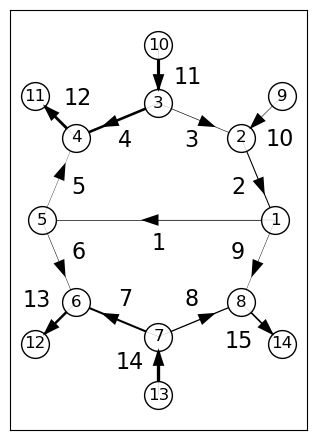

In [11]:
scale = -0.2
rot = -0.2
offset_x = [0]*len(N.e)
offset_y = [0]*len(N.e)
for i,edge in enumerate(N.e):
    i0 = min([edge[0],edge[1]])
    i1 = max([edge[0],edge[1]])        

    x0 = N.v[i0,0]
    y0 = N.v[i0,1]

    x1 = N.v[i1,0]
    y1 = N.v[i1,1]
    
    if i == 0:
        offset_x[i] = 0
        offset_y[i] = scale
    elif i <= 8:
        offset_x[i] = (x0+(x1-x0)/2)*scale
        offset_y[i] = (y0+(y1-y0)/2)*scale
    else: 
        offset_x[i] = (np.cos(rot)*(x0+(x1-x0)/2) - np.sin(rot)*(y0+(y1-y0)/2)) - (x0+(x1-x0)/2)
        offset_y[i] = (np.sin(rot)*(x0+(x1-x0)/2) + np.cos(rot)*(y0+(y1-y0)/2)) - (y0+(y1-y0)/2)
plt.figure(figsize=(8,4.5))

plt.figure(figsize=(4.5,4.5))
N.plot(annotate=True,publication=True,
    ms=20,
    annot_offset_x=offset_x,
    annot_offset_y=offset_y,
    head_width = 0.1,
    width=np.abs(N.q0)*5,
    directions=np.sign(N.q0))
plt.tight_layout()
plt.margins(x=0.1, y=0.1) 
plt.savefig('figures/carrlecoin_schematic.pdf',bbox_inches='tight')

### Figure 2: Carr-Lecoin Polytope Comparison

In [12]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)

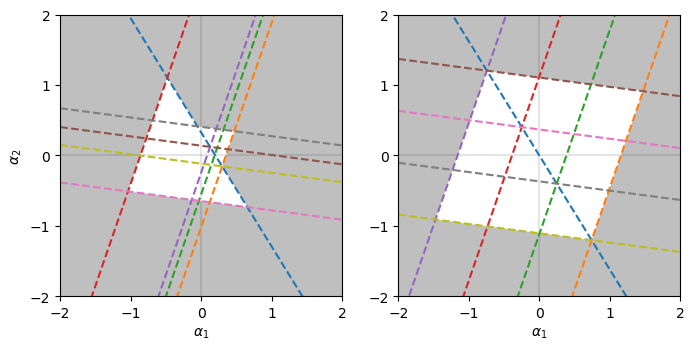

In [13]:
plt.figure(figsize=(8,4.5))

plt.subplot(1,2,1)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
alpha_space_pub(kirchoff=False,legend=False,loc='upper left',corners=[[0,3],[3,6],[6,0],[0,1],[1,7],[7,0],[0,3]])
plt.yticks([-2,-1,0,1,2]);

plt.subplot(1,2,2)
inlets = [8,9,10]
N.set_flow_boundary_conditions('equal',inlets=inlets,seed=2025)
alpha_space_pub(kirchoff=False,legend=False,loc='upper left',corners=[[0,8],[8,4],[4,5],[5,1]])
plt.ylabel('')
plt.yticks([-2,-1,0,1,2]);

plt.savefig('figures/carrlecoin_comparison.pdf',bbox_inches='tight')

### Figure 3: Carr-Lecoin Cells

In [14]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)

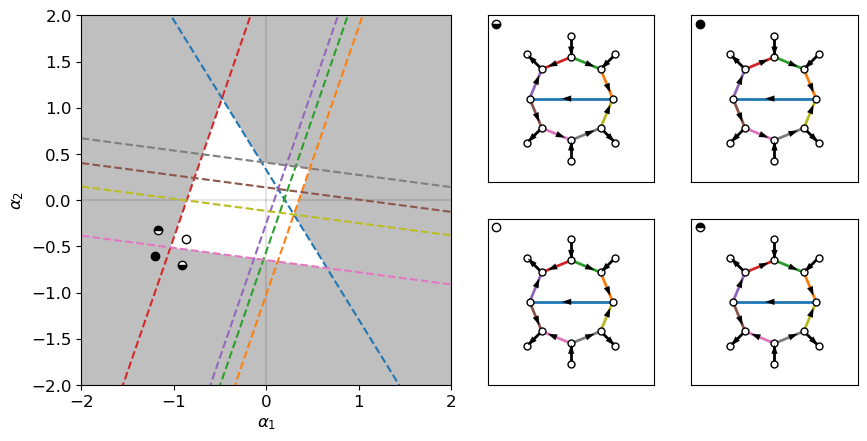

In [15]:
plt.rcParams.update({'font.size': 12}) 
alpha_space_pub(kirchoff=False,legend=False,loc='upper left',corners=[[0,3],[3,6],[6,0],[0,1],[1,7],[7,0],[0,3]])

def plot_inset(a,position=[1.1,0],width=0.45,marker=['ks']):
    inset_ax = main_ax.inset_axes(
      position + 2*[width],  
        xlim=[a[0]-.01,a[0]+.01], ylim=[a[1]-.01,a[1]+.01], 
        xticklabels=[], yticklabels=[]
    )
    q = N.q0 + N.K@a
    # width = np.round(np.abs(q),2)*4
    # width[np.where(width < 1e-2)[0]] = 0
    width = 2*np.ones(N.nVessels)

    plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    colors = [plt_colors[np.where(N.interiorFlows == i)[0][0]] if i in list(N.interiorFlows) else 'k' for i in range(N.nVessels)]
    
    N.plot(ax=inset_ax,directions=np.sign(q),ms=5,width=width,colors=colors,head_width=0.15)
    # for m in marker:
    #     inset_ax.plot(-1.8,1.8,m)
    inset_ax.set_xlim((-2,2))
    inset_ax.set_ylim((-2,2))
    return inset_ax

z = [3,6]

a_star = -np.linalg.inv(N.K[z,:])@N.q0[z]
P = N.K[z,:]/np.linalg.norm(N.K[z,:],axis=0)[:,None]

alphas = []
perts = [[1,-1],[1,1],[-1,-1],[-1,1]]
for pert in perts:
    alphas.append(a_star + 0.15*P.T@np.array(pert))

main_ax = plt.gca()

fillstyles = ['none','bottom','top','full']

for i in range(4):
    inset_ax = plot_inset(alphas[i],position=[1.1+(i//2)*0.55,0.55*(i%2)])
    inset_ax.plot(-1.8,1.8,'ko',
        markeredgecolor='k',
        markerfacecolor='k',
        markerfacecoloralt='w',
        fillstyle=fillstyles[i])
    plt.plot(alphas[i][0],alphas[i][1],'ko',
        markeredgecolor='k',
        markerfacecolor='k',
        markerfacecoloralt='w',
        fillstyle=fillstyles[i])

plt.savefig('figures/carrlecoin_cells.pdf',bbox_inches='tight')

### Figure 4: Simulataneous Reversal

In [18]:
## Three Node with Loop

S = skeleton.NetworkSkeleton()

S.e = [[0,2],[1,5],[2,3],[3,4],[3,4],[4,5],[2,6],[5,6],[6,7]]
S.v = np.array([[0,2],[0,-2],[1,2],[1,1],[1,-1],[1,-2],[2,0],[3,0]])
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))
S.w = np.zeros(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [0,1]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2026)
N.set_hematocrit_boundary_conditions('equal',0.45)

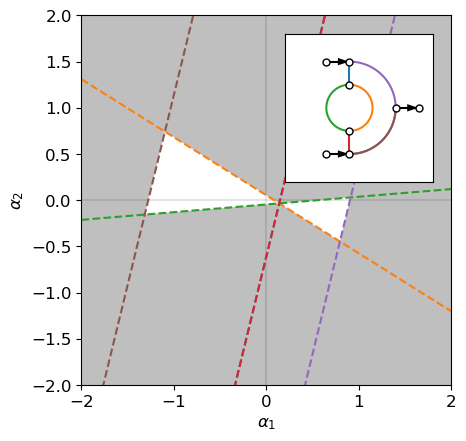

In [19]:
def plot_inset(position=[1,0],width=0.45):
    inset_ax = main_ax.inset_axes(
      position + 2*[width], xticklabels=[], yticklabels=[]
    )
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    
    r = 1.25

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    inset_ax.plot([0,0],[r/2,r],color=colors[0])
    
    t = np.linspace(-np.pi/2,np.pi/2,100)
    x = np.cos(t)
    y = np.sin(t)
    inset_ax.plot(r/2*x,r/2*y,color=colors[1])
    
    t = np.linspace(np.pi/2,3*np.pi/2,100)
    x = np.cos(t)
    y = np.sin(t)
    inset_ax.plot(r/2*x,r/2*y,color=colors[2])
    
    t = np.linspace(-np.pi/2,np.pi/2,100)
    x = np.cos(t)
    y = np.sin(t)
    inset_ax.plot(r*x,r*y,color=colors[4])
    
    t = np.linspace(-np.pi/2,0,100)
    x = np.cos(t)
    y = np.sin(t)
    inset_ax.plot(r*x,r*y,color=colors[5])
    
    
    inset_ax.plot([0,0],[-r/2,-r],color=colors[3])
    
    inset_ax.plot([r,3/2*r],[0,0],'k')
    inset_ax.plot([-r/2,0],[r,r],'k')
    inset_ax.plot([-r/2,0],[-r,-r],'k')
    
    for pt in [[0,r],[0,-r],[-r/2,r],[-r/2,-r],[0,r/2],[0,-r/2],[r,0],[3*r/2,0]]:
        inset_ax.plot(*pt,'wo',ms=5,mec='k')
    
    inset_ax.arrow(r,0,r/4,0,head_width=0.2,lw=0,fc='k',ec='k')
    inset_ax.arrow(-r/2,r,r/4,0,head_width=0.2,lw=0,fc='k',ec='k')
    inset_ax.arrow(-r/2,-r,r/4,0,head_width=0.2,lw=0,fc='k',ec='k')
    
    inset_ax.set_xlim((-1.75,2.25))
    inset_ax.set_ylim((-2,2))

plt.figure()
main_ax = plt.gca()

alpha_space_pub(legend=False,corners=[[3,7],[7,4],[4,3],[3,6],[6,4],[4,3],[3,7]])
plot_inset(position=[.55,.55],width=.4)

plt.savefig('figures/example_unflippable.pdf',bbox_inches='tight')

### Figure 5: Carr-Lecoin Faces

In [20]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)
K_orig = N.K.copy()

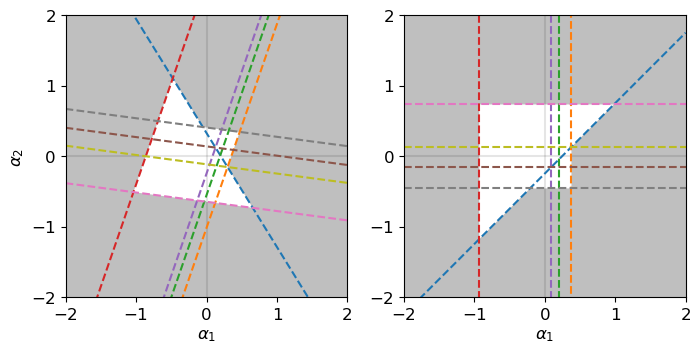

In [21]:
N.K = K_orig.copy()
plt.figure(figsize=(8,4.5))
plt.subplot(1,2,1)
plt.yticks([-2,-1,0,1,2])
alpha_space_pub(corners=[[0,3],[3,6],[6,0],[0,1],[1,7],[7,0],[0,3]])

N.K = N.K@np.linalg.inv(N.K[[2,6],:])/2.5
plt.subplot(1,2,2)
plt.yticks([-2,-1,0,1,2])
alpha_space_pub(corners=[[0,3],[3,6],[6,0],[0,1],[1,7],[7,0],[0,3]])
plt.ylabel('')

plt.savefig('figures/carrlecoin_faces.pdf',bbox_inches='tight')

### Figure 6: Carr-Lecoin Vertices

In [22]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,12]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2025)
N.set_hematocrit_boundary_conditions('equal',0.4)

N.K = N.K@np.linalg.inv(N.K[[2,6],:])/2.5

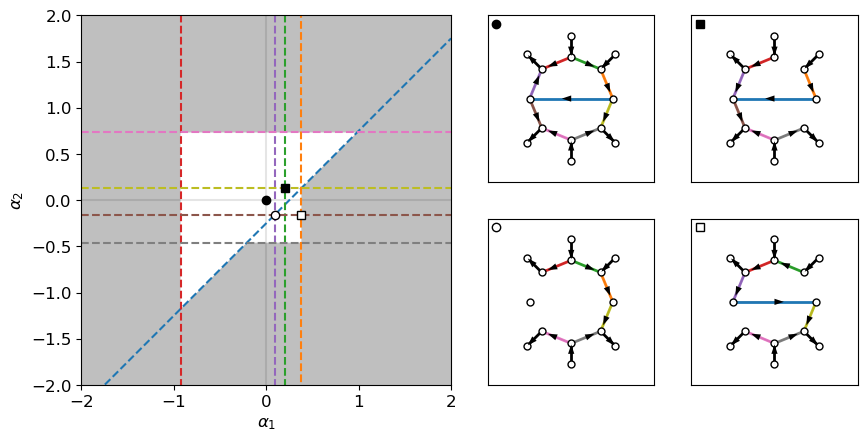

In [24]:
plt.rcParams.update({'font.size': 12}) 
alpha_space_pub(kirchoff=False,legend=False,loc='upper left',corners=[[0,3],[3,6],[6,0],[0,1],[1,7],[7,0],[0,3]])

def plot_inset(a,position=[1.1,0],width=0.45,marker='ks'):
    inset_ax = main_ax.inset_axes(
      position + 2*[width],  
        xlim=[a[0]-.01,a[0]+.01], ylim=[a[1]-.01,a[1]+.01], 
        xticklabels=[], yticklabels=[]
    )
    q = N.q0 + N.K@a
    width = np.round(np.abs(q),2)*4
    width = 2*np.ones(N.nVessels)
    width[np.where(np.abs(q) < 1e-2)[0]] = 0

    plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    
    colors = [plt_colors[np.where(N.interiorFlows == i)[0][0]] if i in list(N.interiorFlows) else 'k' for i in range(N.nVessels)]
    
    N.plot(ax=inset_ax,directions=np.sign(q),ms=5,width=width,colors=colors,head_width=0.15)
    inset_ax.plot(-1.8,1.8,marker,mec='k')
    inset_ax.set_xlim((-2,2))
    inset_ax.set_ylim((-2,2))

markers = ['wo','ko','ws','ks']

alphas = [-np.linalg.inv(N.K[[0,4],:])@N.q0[[0,4]],
          np.array([0,0]), 
          -np.linalg.inv(N.K[[1,5],:])@N.q0[[1,5]],
          -np.linalg.inv(N.K[[2,8],:])@N.q0[[2,8]]
          ]

main_ax = plt.gca()
for i in range(len(alphas)):
    plot_inset(alphas[i],position=[1.1+(i//2)*0.55,0.55*(i%2)],marker=markers[i])
    main_ax.plot(*alphas[i],markers[i],mec='k')

plt.savefig('figures/carrlecoin_vertices.pdf',bbox_inches='tight')

### Figure 7: Carr-Lecoin $|r_0|_\infty$ contours

In [25]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,10]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=1234)
N.set_hematocrit_boundary_conditions('equal',0.45)

n_grid = 50
a_min = -1.5
a_max = 1.5
A1,A2 = np.meshgrid(np.linspace(a_min,a_max,n_grid),np.linspace(a_min,a_max,n_grid))
r_max_plasma = np.zeros(A1.shape)
r_max = np.zeros(A1.shape)

for i in range(A1.shape[0]):
    for j in range(A1.shape[1]):
        a1 = A1[i,j]
        a2 = A2[i,j]

        a = np.array([a1,a2])
        
        q = N.q0 + N.K@a

        c = np.ones(len(N.e))
        A_ub = -np.eye(len(N.e))
        b_ub = -1*np.ones(len(N.e))
        
        R = np.eye(len(q))
        A_eq = (N.K).T@R@np.diag(q)
        b_eq = np.zeros(N.k)
        result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,None))

        if result.success:
            r_max_plasma[i,j] = np.max(result.x)
        else:
            r_max_plasma[i,j] = np.nan

        R = np.diag(np.exp(get_h(q)*N.delta))
        A_eq = (N.K).T@R@np.diag(q)
        b_eq = np.zeros(N.k)
        result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,None))

        if result.success:
            r_max[i,j] = np.max(result.x)
        else:
            r_max[i,j] = np.nan            

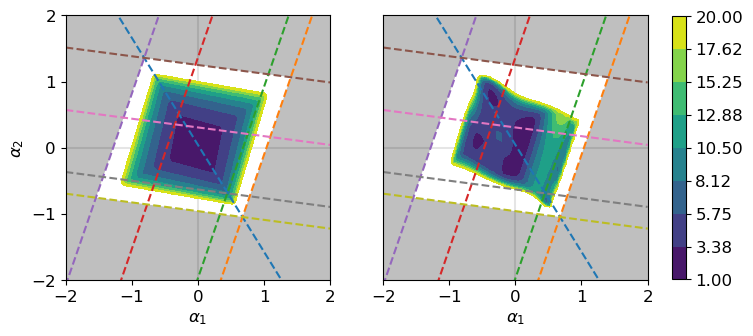

In [26]:
rU = 20
n_contour = 9

fig, axs = plt.subplots(1, 2,figsize=(8,4.5))

plt.subplot(1,2,1)
alpha_space_pub(corners=[[1,8],[8,4],[4,5],[5,1]])
plt.yticks([-2,-1,0,1,2])
plt.contourf(A1,A2,r_max_plasma,np.linspace(1,rU,n_contour))

plt.subplot(1,2,2)
alpha_space_pub(corners=[[1,8],[8,4],[4,5],[5,1]])
plt.ylabel('')
plt.yticks([])

plt.contourf(A1,A2,r_max,np.linspace(1,rU,n_contour))
plt.colorbar(fraction=0.02125, pad=0.04, ax=axs[:])

# plt.tight_layout()

plt.savefig('figures/r_max_contours.pdf',bbox_inches='tight')

### Figure 8: Carr-LeCoin: Kirchoff Contours

In [27]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,10]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2026)
N.set_hematocrit_boundary_conditions('equal',0.0)

/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/896082825.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim((a_max,a_max))
/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/896082825.py:15: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim((a_max,a_max))


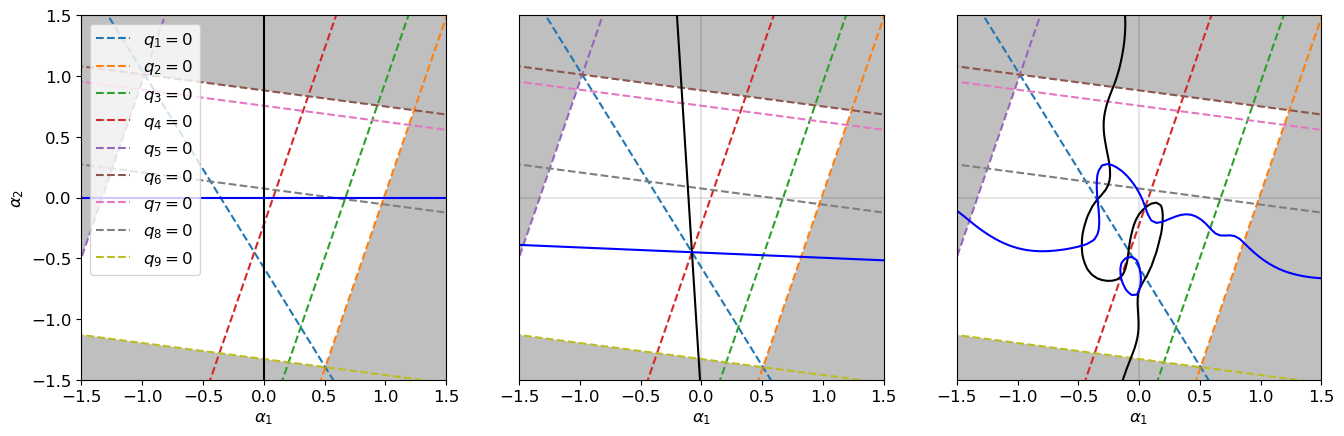

In [28]:
plt.figure(figsize=(16,9))
        
a_min = -1.5
a_max = 1.5
n_grid=100
z = [0,3]
corners = [[5,4],[4,8],[8,1],[1,5]]

####
plt.subplot(1,3,1)
#np.random.seed(2025)
N.l = np.ones(N.nVessels)
N.d = np.ones(N.nVessels)
N.set_hematocrit_boundary_conditions('equal',0.0)
alpha_space_pub(legend=True,kirchoff=True,a_min=a_min,a_max=a_max,n_loop_grid=n_grid,corners=corners)

####
plt.subplot(1,3,2)
result = tune_r0(z,all_plasma=False,pert=1e-6)
N.l = result.x
N.d = np.ones(N.nVessels)

alpha_space_pub(legend=False,kirchoff=True,a_min=a_min,a_max=a_max,n_loop_grid=n_grid,corners=corners)
plt.ylabel('')
plt.yticks([])

####
plt.subplot(1,3,3)
N.d[z] = 2
N.set_hematocrit_boundary_conditions('equal',0.45)

alpha_space_pub(legend=False,kirchoff=True,a_min=a_min,a_max=a_max,n_loop_grid=n_grid,corners=corners)
plt.ylabel('')
plt.yticks([])

plt.savefig('figures/tuning_triptych.pdf',bbox_inches='tight')

### Table 1 and Table 2: Network Information and Equilibria Results

In [8]:
def results_plot(N,filename):
    u_s = []
    u_h = []
    Q = []
    to_delete = []
    for i in range(N.equilibria.shape[1]):
        N.set_state(N.equilibria[:,i])

        if max(N.h) > 1 or min(N.h) < 0:
            to_delete.append(i)
            continue

        Q.append(N.q)
        
        u_s.append([int(x) for x in np.sign(N.q[N.z])])
        unique = True
        for uu in u_h:
            if np.linalg.norm(uu - N.h) <= 1e-3:
                unique = False
                to_delete.append(i)
                break
        if unique: 
            u_h.append(N.h)

    N.equilibria = np.delete(N.equilibria, to_delete, axis=1)
    u_s = list(set([tuple(s) for s in u_s]))
    Q = np.array(Q)
    
    plt.figure(figsize=(16,9))
    plt.subplot(1,2,1)
    sns.heatmap(np.sign(Q),cbar=False)
    plt.yticks([])
    plt.ylabel('Flow direction')
    plt.title(r'$|u_s|$' + f'= {len(u_s)}');
    plt.xlabel('Vessel Index');
    plt.subplot(1,2,2)
    sns.heatmap(N.equilibria.T)
    plt.yticks([])
    plt.ylabel('Hematocrit')
    plt.title(r'$|u_h|$' + f'= {len(u_h)}');
    plt.xlabel('Vessel Index');
    plt.savefig(f'figures/{filename}.pdf',bbox_inches='tight')
    

[ 5  7 14 16 18 22 25 31]


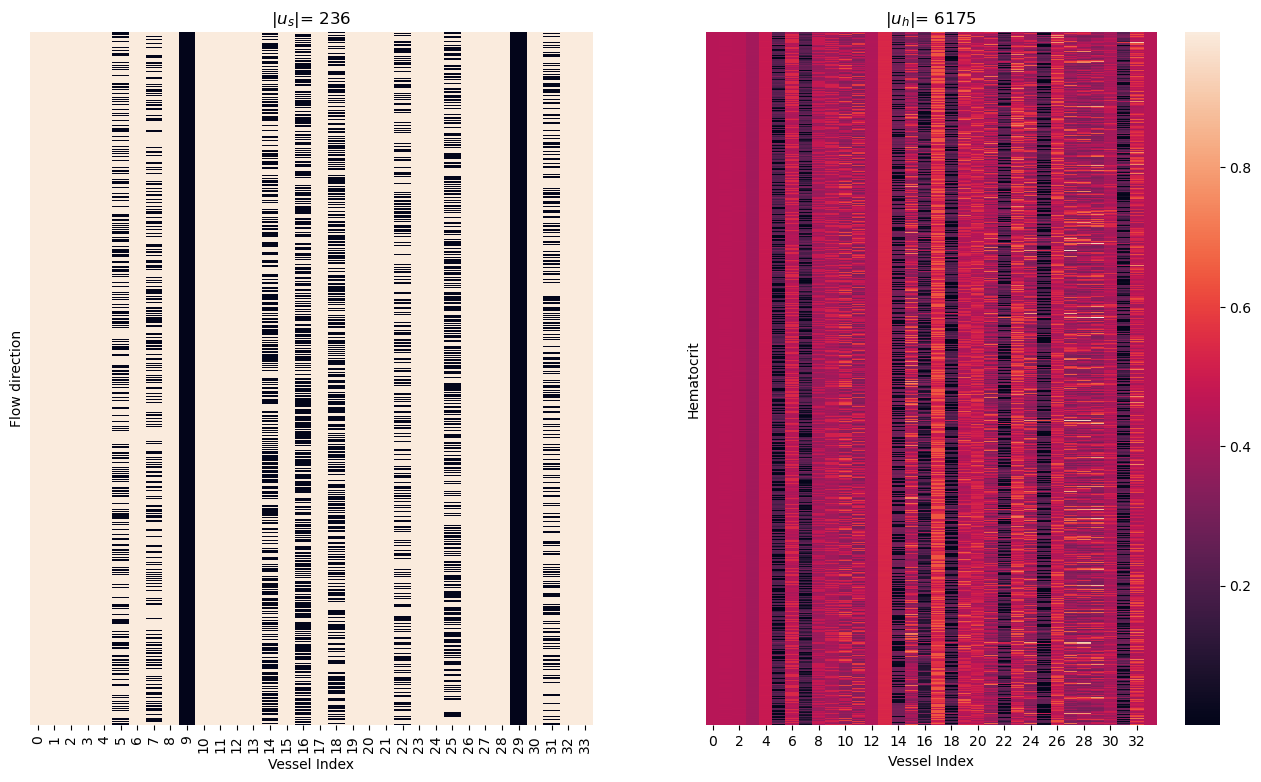

In [9]:
# f = open('data/forouzan.p','rb')
# N = pickle.load(f)
# print(np.where(N.z)[0])
# results_plot(N,'forouzan_q_h')
# f.close()

In [363]:
f = open('data/forouzan.p','rb')
N = pickle.load(f)
network_info()
f.close()

|V_G|: 24
|E_G|: 34
k: 11
z: 8
|V_A|: 5192399.999999932
log(|V_A|): 15.462706576000963


(array([ 1,  4,  9, 12, 14, 16, 18, 19, 39]),)


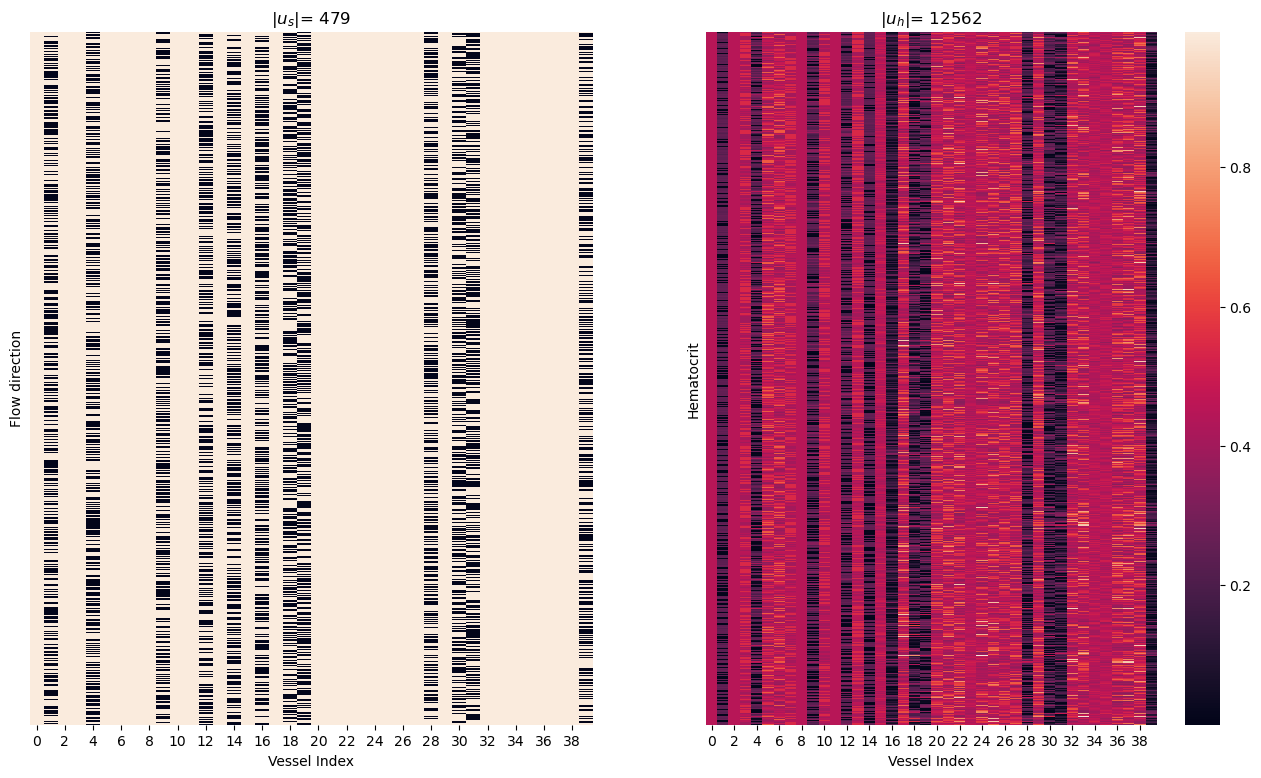

In [361]:
# f = open('data/mesh.p','rb')
# N = pickle.load(f)
# print(np.where(N.z))
# results_plot(N,'mesh_q_h')
# f.close()

In [365]:
f = open('data/mesh.p','rb')
N = pickle.load(f)
network_info()
f.close()

|V_G|: 32
|E_G|: 40
k: 9
z: 9
|V_A|: 1911000.0000000119
log(|V_A|): 14.463137223222416


(array([ 2,  7, 10, 14, 17, 24, 27, 28, 29, 33, 38, 41, 47, 52, 59, 64, 67]),)


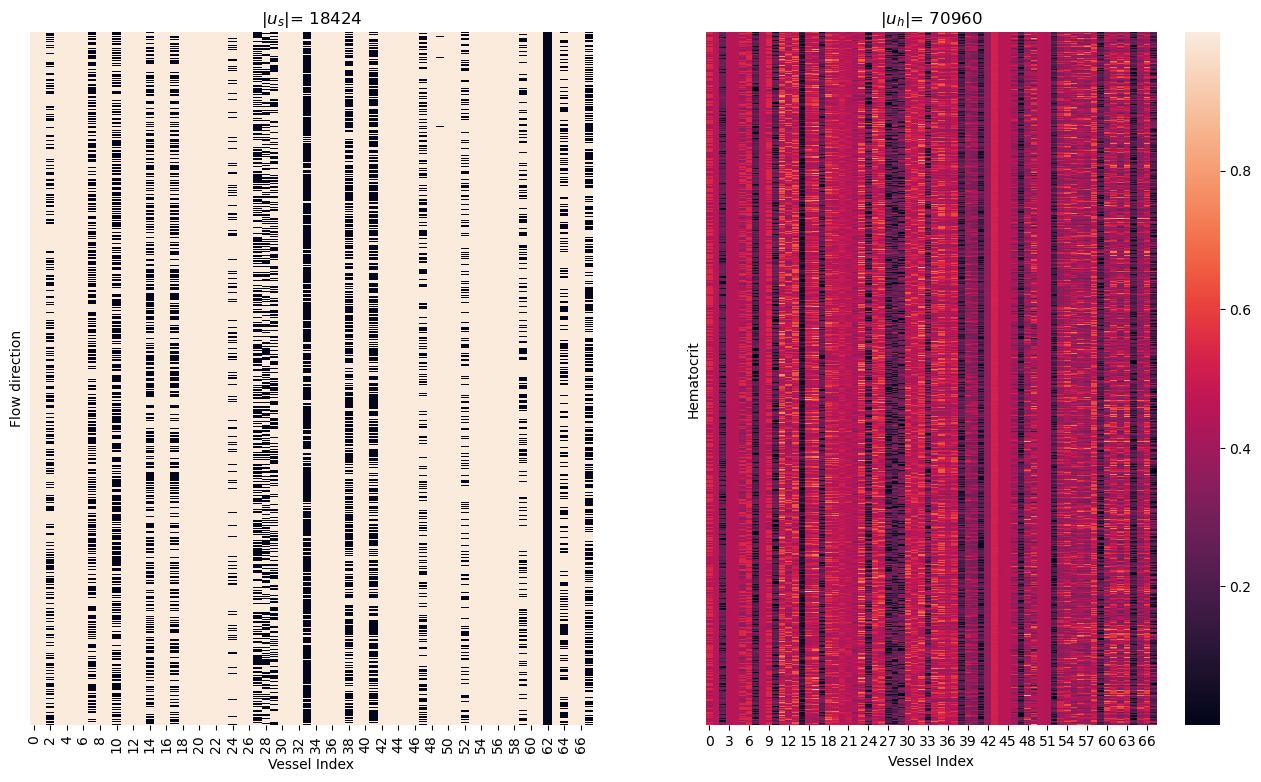

In [346]:
# f = open('data/random.p','rb')
# N = pickle.load(f)
# print(np.where(N.z))
# results_plot(N,'random_q_h')
# f.close()

In [366]:
f = open('data/random.p','rb')
N = pickle.load(f)
network_info()
f.close()

|V_G|: 50
|E_G|: 68
k: 19
z: 17
|V_A|: 9122210621553.113
log(|V_A|): 29.84173328335658


### Figure 9: Reversability Schematics

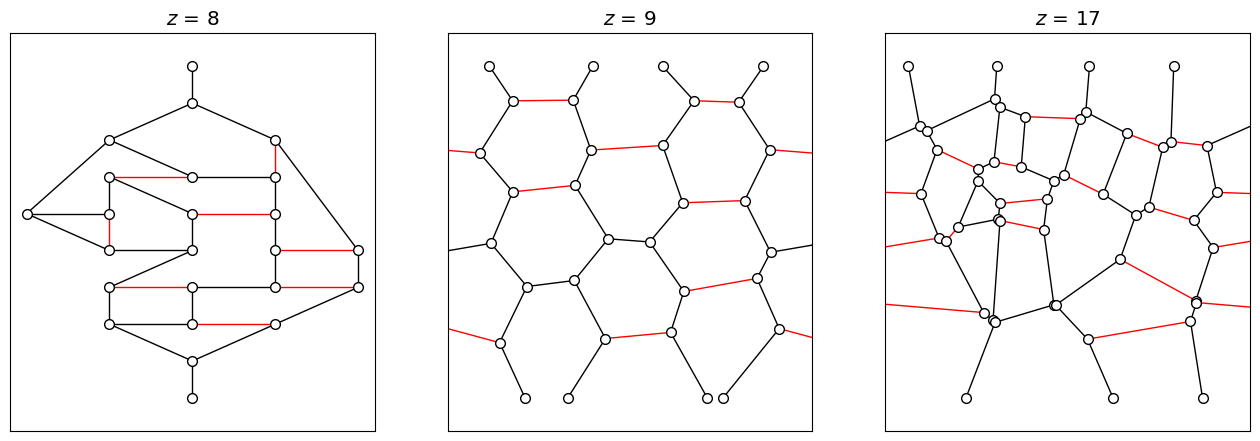

In [29]:
plt.figure(figsize=(16,9))

def normalize(x):
    return 

for i,network in enumerate(['forouzan','mesh','random']):
    f = open(f'data/{network}.p','rb')
    N = pickle.load(f)
    f.close()
    
    colors = ['r' if N.z[i] else 'k' for i in range(N.nVessels)]
    if network == 'forouzan':
        normalize = lambda x: (x - np.min(x))/(np.max(x) - np.min(x))
        N.v = np.array(N.v,'float')
        N.v[:,0] = 1 - normalize(N.v[:,0]) 
        N.v[:,1] = normalize(N.v[:,1]) + 0.05
    
        N.v = N.v[:,[1,0]]
        
#     if network == 'random':
#         ind_rev = find_reversible_edges(N,np.zeros(N.k))
#         for j in range(N.nVessels):
#             if j in ind_rev and not N.z[j]:
#                 colors[j] = 'b'
    
    
    plt.subplot(1,3,i+1)
    N.plot(colors=colors,ms=7)
    plt.title(f"$z$ = " + str(int(sum(N.z))))
    plt.xlim((0,1.1))
    plt.ylim((-0.1,1.1))
    
plt.savefig('figures/results_schematics.pdf',bbox_inches='tight')

### Figure 10: Continuatinons

In [30]:
S = skeleton.GeneralizedCarrLeCoin(3,3)
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))

physParams= {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = [8,9,10]
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2026)
N.set_hematocrit_boundary_conditions('equal',0.1)

In [31]:
hin_lo = 0.235
z = [0,3]
a_z = -np.linalg.inv(N.K[z,:])@N.q0[z] + 1e-6*np.random.random(N.k)
q_z = N.K@a_z + N.q0

N.set_hematocrit_boundary_conditions('equal',hin_lo)

result = tune_r0(z,all_plasma=False,pert=1e-6)
N.l = result.x

# N.l += np.random.random(N.nVessels)*0.1

In [32]:
def F_equi(a):
    # get q
    q = N.K@a + N.q0
    
    # get h
    h = get_h(q)
    
    # get r
    r = N.l/N.d**4*np.exp(N.delta*h)
    
    # return Kirchoff = K'@R@q
    return N.K.T@np.diag(r)@q

In [33]:
from continuation import *

def F(y):
    N.set_hematocrit_boundary_conditions('equal',y[-1])
    return F_equi(y[:-1])

hin_high = 0.75

N.set_hematocrit_boundary_conditions('equal',hin_high)

eqs = []
for i in range(200):
    a = (np.random.random(2)-0.5)*2
    a = sp.optimize.fsolve(F_equi,a)
    if np.linalg.norm(F_equi(a)) < 1e-6:
        flag = True
        for eq in eqs:
            if np.linalg.norm(eq-a) < 1e-6:
                flag = False
                break
        if flag:
            eqs.append(a)

m = -np.inf*np.ones(3)
m[-1] = 0
M = np.inf*np.ones(3)
M[-1] = 0.9
opt = Options(minValues=m, maxValues=M, maxSteps=1e4)

continuations_detuned = {}
for i,x0 in enumerate(eqs):
    print('Starting continuation...')
    y0 = np.append(x0,hin_high)
    print(y0)
    t0 = np.append(np.zeros(np.shape(x0)),.1)

    C = Continuer(F,y0,1e-3,opt)
    Y = C.get_continuation()
    Y = Y.T

    continuations_detuned[i] = Y

/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/329570395.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  a = sp.optimize.fsolve(F_equi,a)
/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/329570395.py:14: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a = sp.optimize.fsolve(F_equi,a)


Starting continuation...
[ 0.24919349 -0.10961796  0.75      ]
Starting continuation...
[-0.31226233  0.42946078  0.75      ]
Starting continuation...
[-0.41944627  0.05374379  0.75      ]
Starting continuation...
[-0.18381017 -0.72181232  0.75      ]
Starting continuation...
[-0.00198293 -0.89549849  0.75      ]
Starting continuation...
[-0.56683812 -0.41162534  0.75      ]
Starting continuation...
[ 0.05383296 -0.72039785  0.75      ]
Starting continuation...
[0.1055082  0.01209785 0.75      ]
Starting continuation...
[-0.0851971  -0.46778402  0.75      ]


In [34]:
l_cusp = np.array([0.01850713,
                   1.80000492,
                   0.81417745,
                   1.00000001,
                   1.50978677,
                   2.39178214,
                   0.20047894,
                   0.46261374,
                   4.272451,
                   1.,
                   1.,
                   1.,
                   1.,
                   1.,
                   1.])
N.l = l_cusp.copy()

hin_high = 0.75

N.set_hematocrit_boundary_conditions('equal',hin_high)

eqs = []
for i in range(200):
    a = (np.random.random(2)-0.5)*2
    a = sp.optimize.fsolve(F_equi,a)
    if np.linalg.norm(F_equi(a)) < 1e-6:
        flag = True
        for eq in eqs:
            if np.linalg.norm(eq-a) < 1e-6:
                flag = False
                break
        if flag:
            eqs.append(a)
            
def F(y):
    N.set_hematocrit_boundary_conditions('equal',y[-1])
    return F_equi(y[:-1])

m = -np.inf*np.ones(3)
m[-1] = 0
M = np.inf*np.ones(3)
M[-1] = 0.9
opt = Options(minValues=m, maxValues=M, maxSteps=1e4)

continuations_tuned = {}
for i,x0 in enumerate(eqs):
    print('Starting continuation...')
    y0 = np.append(x0,hin_high)
    print(y0)
    t0 = np.append(np.zeros(np.shape(x0)),.1)

    C = Continuer(F,y0,1e-3,opt)
    Y = C.get_continuation()
    Y = Y.T

    continuations_tuned[i] = Y

/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/1994925136.py:25: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  a = sp.optimize.fsolve(F_equi,a)
/var/folders/d3/rglspjrn6737y_qspp1kxq880000gn/T/ipykernel_38613/1994925136.py:25: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  a = sp.optimize.fsolve(F_equi,a)


Starting continuation...
[-0.18706071 -0.76226789  0.75      ]
Starting continuation...
[0.08946829 0.03651503 0.75      ]
Starting continuation...
[-0.59395606 -0.43324966  0.75      ]
Starting continuation...
[-0.30219898  0.41293683  0.75      ]
Starting continuation...
[ 0.06344052 -0.69283731  0.75      ]
Starting continuation...
[-0.41685276  0.08014354  0.75      ]
Starting continuation...
[ 0.26518487 -0.10812938  0.75      ]
Starting continuation...
[-0.07926376 -0.4508872   0.75      ]
Starting continuation...
[-0.01502324 -0.92034453  0.75      ]


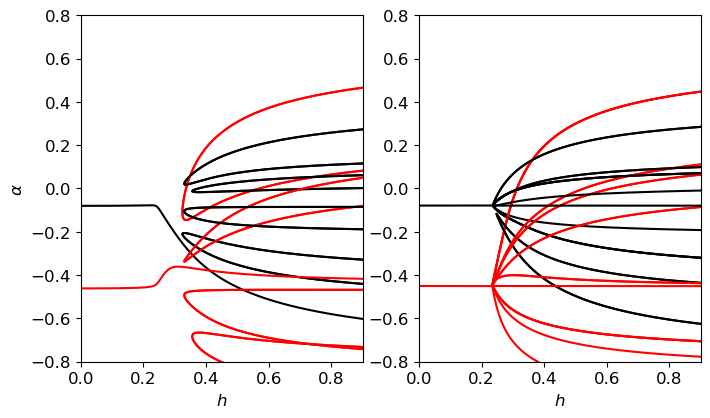

In [35]:
plt.figure(figsize=(8,4.5))
plt.subplot(1,2,1)

for i,c in continuations_detuned.items():
    plt.plot(c[:,-1],c[:,0],'k')
    plt.plot(c[:,-1],c[:,1],'r')

plt.xlabel(r'$h$')
plt.ylabel(r'$\alpha$')
plt.xlim((0,0.9))
plt.ylim((-0.8,0.8))
plt.subplot(1,2,2)

for i,c in continuations_tuned.items():
    plt.plot(c[:,-1],c[:,0],'k')
    plt.plot(c[:,-1],c[:,1],'r')
plt.xlabel(r'$h$')
plt.xlim((0,0.9))
plt.ylim((-0.8,0.8))


plt.savefig('figures/continuations.pdf',bbox_inches='tight')

### Figure 11: Rat

In [56]:
def suppress_degree_two_node(G: nx.Graph, u):
    v, w = list(G.neighbors(u))
    
    G.remove_edge(u, v)
    G.remove_edge(u, w)

    if v != w and not G.has_edge(v, w):
        G.add_edge(v, w)

    G.remove_node(u)
    
def suppress_all_degree_two_nodes(G: nx.Graph):
    changed = True
    while changed:
        changed = False
        for u in [n for n, d in G.degree() if d == 2]:
            if u in G and G.degree(u) == 2:
                suppress_degree_two_node(G, u)
                changed = True


df = pd.read_csv('data/rat_network.csv')

G = nx.Graph()

for i in range(df.shape[0]):
    G.add_edge(df['EndNodes_1'][i],df['EndNodes_2'][i])
    
suppress_all_degree_two_nodes(G)

nodes = list(G.nodes())
nodes.sort()

node_mapper = dict(zip(nodes, range(G.number_of_nodes())))

H = nx.Graph()

for edge in list(G.edges):
    H.add_edge(node_mapper[edge[0]],node_mapper[edge[1]])


pos = nx.spring_layout(H)

e = [[int(e[0]),int(e[1])] for e in list(H.edges)]

v = np.zeros((H.number_of_nodes(),2))
for i in range(H.number_of_nodes()):
    v[i,:] = pos[i]    

S = skeleton.NetworkSkeleton()

S.e = e
S.v = v
S.l = np.ones(len(S.e))
S.d = np.ones(len(S.e))
S.w = np.zeros(len(S.e))

physParams = {'pPlasma':2, 'delta':np.log(100), 'seed':1234, 
              'bc_type':'flow','pq_bcs':np.zeros(len(S.v)),
              'h_bcs':np.zeros(len(S.e))}
params = {**S.get(), **physParams}

N = Network(params)
inlets = list(N.exteriorNodes[::2])
hin = 0.4
N.set_flow_boundary_conditions('random',inlets=inlets,seed=2024)
N.set_hematocrit_boundary_conditions('equal',hin)  

In [58]:
z = build_z_greedy(rmax=18,pert=1e-7)

IntProgress(value=0, max=121)

In [61]:
result = tune_r0(z,pert=1e-7)
max(result.x)

np.float64(17.262410327788082)

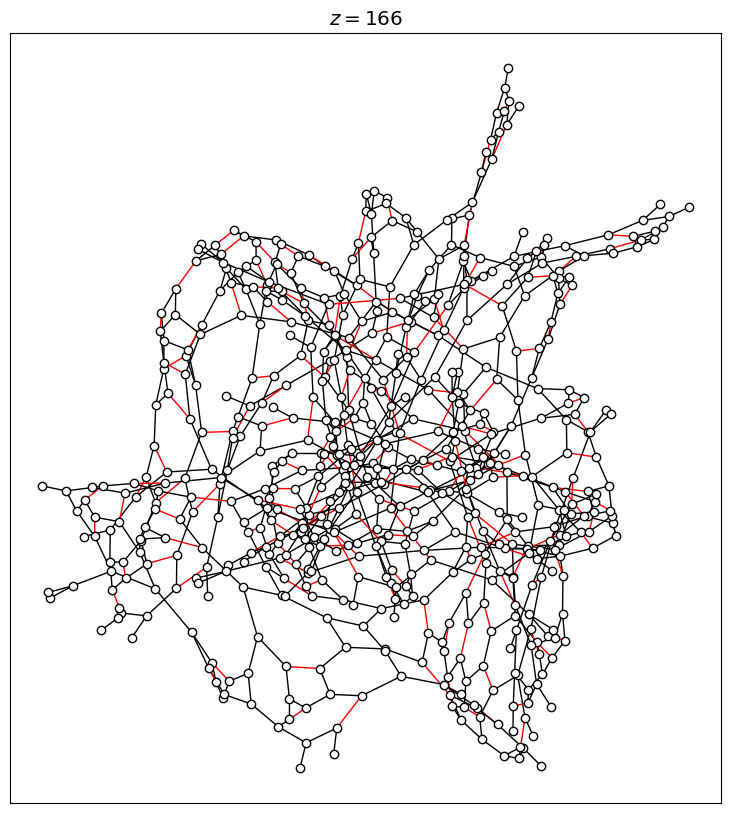

In [60]:
plt.figure(figsize=(10,10))
N.plot(colors=['r' if zz else 'k' for zz in z],ms=6)
plt.title(r'$z = ' + str(sum(z)) + '$')
plt.savefig('figures/rat.pdf',bbox_inches='tight')